# Analyzing the Mercari children's book dataset

### Import libraries and files

In [60]:
%matplotlib notebook
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split




In [4]:
os.chdir('/Users/mleong/github/used-books')
books = pd.read_csv('used-book-data.csv')
books.head()

,brand,category,condition,description,id,posted,price,seller_name,shipping,sold,title
0,NaN,"Other,Books,Children's books",New,Free with another book purchase,84914972647,07/10/17,$3,C Sells,$4.00 | from Texas,Buy now,Book
1,NaN,"Other,Books,Children's books",New,Book-When Bad Thinds Happen in God's Wonderful...,28411714700,07/15/17,$3,Investinyou,$4.00 | 3+ days | from Texas,Buy now,Book- When Bad Things Happen
2,NaN,"Other,Books,Children's books",New,This listing is for one book. Please let me kn...,21933816748,05/26/19,$11,HWalters55,Free | from Washington,Buy now,Usborne Wipe-Clean- NEW
3,NaN,"Other,Books,Children's books",New,Brand new. Never used. Ask me about bundling.,89750511304,11/11/17,$3,Bargain hauls,$4.00 | 3+ days | from Minnesota,Buy now,Jingle Bells Book
4,NaN,"Other,Books,Children's books",New,My Sister The Vampire Vampalicious. New softco...,496308655,08/19/16,$4,Dustyattic,Free | from Connecticut,Buy now,My Sister The Vampire


In [5]:
# Row count
rows = books.shape[0]
print("Number of rows: ", str(rows))

# Column count
columns = books.shape[1]
print("Number of columns: ", str(columns))

# Column names
print("Column names: ", str(books.columns))

# Indexing method
print("Index method: ", str(books.index))

# Data types of all columns
print("Data types for entire dataframe: ")
books.info()

# Data type of particular column
print("Data type of price column specifically is: ", str(books.price.dtype))



Number of rows:  49481
Number of columns:  11
Column names:  Index(['brand', 'category', 'condition', 'description', 'id', 'posted',
       'price', 'seller_name', 'shipping', 'sold', 'title'],
      dtype='object')
Index method:  RangeIndex(start=0, stop=49481, step=1)
Data types for entire dataframe: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49481 entries, 0 to 49480
Data columns (total 11 columns):
brand          25163 non-null object
category       49478 non-null object
condition      49481 non-null object
description    49481 non-null object
id             49481 non-null int64
posted         49481 non-null object
price          49481 non-null object
seller_name    49481 non-null object
shipping       49481 non-null object
sold           49481 non-null object
title          49481 non-null object
dtypes: int64(1), object(10)
memory usage: 4.2+ MB
Data type of price column specifically is:  object


### Clean-up time!

In [6]:
# eliminate duplicate rows
books = books.drop_duplicates()
books.shape[0]

22134

In [7]:
# id: convert to string
books.id = books.id.astype(str)
print("Data type of id column specifically is: ", str(books.id.dtype))

Data type of id column specifically is:  object


In [8]:
# posted: convert to datetime
books.posted = pd.to_datetime(books.posted)
books['posted'].head()

0   2017-07-10
1   2017-07-15
2   2019-05-26
3   2017-11-11
4   2016-08-19
Name: posted, dtype: datetime64[ns]

In [9]:
# sold: combine buy now and add to cart categories to be 'for sale'
books = books.replace('Buy now', 'available')
books.sold.unique()

array(['available', 'SOLD'], dtype=object)

In [10]:
# price: modify to eliminate '$' sign and convert to number
books['price'] = books['price'].str.replace(',', '')
books['price'] = books['price'].str.replace('$', '')
books['price'] = books['price'].astype(int)
books.price

0         3
1         3
2        11
3         3
4         4
5         9
6         3
7         3
8         6
9        16
10       16
11       16
12       14
13       14
14       16
15       10
16       14
17       19
18        5
19        5
20        5
21        5
22       15
23        5
24       17
25       20
26       20
27       17
28       14
29       17
         ..
49349     5
49350     5
49351     5
49352     5
49353     5
49354     5
49355     5
49356     5
49357     5
49358    12
49359    11
49360    10
49361    12
49362    10
49363    10
49364    16
49365    15
49366    15
49367    15
49368    14
49369    18
49370    10
49374     5
49380    41
49382    48
49387    30
49399     5
49421    30
49476    53
49477    23
Name: price, Length: 22134, dtype: int64

In [11]:
books.shipping

0                          $4.00 | from Texas
1                $4.00 | 3+ days | from Texas
2                      Free | from Washington
3            $4.00 | 3+ days | from Minnesota
4                     Free | from Connecticut
5                        Free | from Illinois
6            $4.00 | 3+ days | from Minnesota
7               $4.00 | 2+ days | from Nevada
8              Free | 3+ days | from Michigan
9             $5.25 | 3+ days | from Illinois
10                     Free | from California
11                          Free | from Texas
12                 Free | from South Carolina
13         Free | 3+ days | from Pennsylvania
14                       Free | from Arkansas
15               $7.00 | 2+ days | from Texas
16       Free | 3+ days | from North Carolina
17                       Free | from Illinois
18                      $4.00 | from New York
19               $6.50 | 3+ days | from Texas
20       $4.25 | 3+ days | from West Virginia
21                     Free | from

In [12]:
shipping_string = ('Free | 3+ days | from Florida')
shipping_after = shipping_string.split(" | ")
shipping_after

['Free', '3+ days', 'from Florida']

In [13]:
# shipping: create new column "shipping_cost" that is continuous variable from $0 to whatever shipping fee is
def shipping_cost(shipping_string):
    shipping_after = shipping_string.split(" | ")
    if 'Free' in shipping_after[0]:
        shipping_cost = 0
    elif '$' in shipping_after[0]:
        shipping_cost = shipping_after[0]
        shipping_cost = shipping_cost.replace('$', '') 
    else:
        shipping_cost = None
    return shipping_cost

books['shipping_cost'] = books['shipping'].apply(shipping_cost)
books.shipping_cost = pd.to_numeric(books.shipping_cost, errors='coerce')
books.shipping_cost

0         4.00
1         4.00
2         0.00
3         4.00
4         0.00
5         0.00
6         4.00
7         4.00
8         0.00
9         5.25
10        0.00
11        0.00
12        0.00
13        0.00
14        0.00
15        7.00
16        0.00
17        0.00
18        4.00
19        6.50
20        4.25
21        0.00
22        0.00
23        5.25
24        6.00
25        5.25
26        0.00
27        4.25
28       11.00
29        3.80
         ...  
49349     4.00
49350     5.25
49351     5.25
49352     6.50
49353     4.25
49354     4.25
49355     4.25
49356     4.25
49357     4.25
49358     0.00
49359     4.25
49360     0.00
49361     0.00
49362     5.25
49363     4.00
49364     0.00
49365     0.00
49366     4.25
49367     0.00
49368     0.00
49369     0.00
49370     0.00
49374     5.25
49380     0.00
49382     0.00
49387     9.00
49399     4.25
49421     9.00
49476     0.00
49477     0.00
Name: shipping_cost, Length: 22134, dtype: float64

In [14]:
# shipping: create new simpler column "shipping_time" that is number of days to arrival
def shipping_time(shipping_string):
    if 'days' in shipping_string:
        shipping_after = shipping_string.split(" | ")
        if 'days' in shipping_after[0]:
            shipping_time = shipping_after[0]
            shipping_time = shipping_time.replace('+ days', '')
        elif 'days' in shipping_after[1]:
            shipping_time = shipping_after[1]
            shipping_time = shipping_time.replace('+ days', '')
        else:
            shipping_time = None
    else:
        shipping_time = None
    return shipping_time

books['shipping_time'] = books['shipping'].apply(shipping_time)
books.shipping_time

0        None
1           3
2        None
3           3
4        None
5        None
6           3
7           2
8           3
9           3
10       None
11       None
12       None
13          3
14       None
15          2
16          3
17       None
18       None
19          3
20          3
21       None
22       None
23          2
24       None
25          3
26          2
27          2
28          2
29          8
         ... 
49349       3
49350       3
49351       3
49352       3
49353       3
49354       3
49355       3
49356       3
49357       3
49358    None
49359       3
49360    None
49361       2
49362       2
49363       3
49364       3
49365       3
49366       3
49367       3
49368    None
49369    None
49370    None
49374       3
49380    None
49382    None
49387    None
49399       3
49421    None
49476       3
49477    None
Name: shipping_time, Length: 22134, dtype: object

In [15]:
# shipping: create new simpler column "shipping_location" that is just the state product is coming from
def shipping_location(shipping_string):
    if 'from' in shipping_string:
        shipping_after = shipping_string.split(" | ")
        if 'from' in shipping_after[0]:
            shipping_location = shipping_after[0]
            shipping_location = shipping_location.replace('from ', '')
        elif 'from' in shipping_after[1]:
            shipping_location = shipping_after[1]
            shipping_location = shipping_location.replace('from ', '')
        elif 'from' in shipping_after[2]:
            shipping_location = shipping_after[2]
            shipping_location = shipping_location.replace('from ', '')
        else:
            shipping_location = None
    else:
        shipping_location = None
    return shipping_location

books['shipping_location'] = books['shipping'].apply(shipping_location)
books.shipping_location

0                 Texas
1                 Texas
2            Washington
3             Minnesota
4           Connecticut
5              Illinois
6             Minnesota
7                Nevada
8              Michigan
9              Illinois
10           California
11                Texas
12       South Carolina
13         Pennsylvania
14             Arkansas
15                Texas
16       North Carolina
17             Illinois
18             New York
19                Texas
20        West Virginia
21           California
22       North Carolina
23               Oregon
24        Massachusetts
25             Colorado
26              Florida
27           California
28              Arizona
29             New York
              ...      
49349             Texas
49350          Illinois
49351          Maryland
49352           Indiana
49353          Arkansas
49354           Florida
49355        Washington
49356              Ohio
49357           Florida
49358          Illinois
49359       Miss

In [16]:
# total price: new column that is sum of price and shipping fee
books['total_price'] = books['price']+books['shipping_cost']
books.total_price

0         7.00
1         7.00
2        11.00
3         7.00
4         4.00
5         9.00
6         7.00
7         7.00
8         6.00
9        21.25
10       16.00
11       16.00
12       14.00
13       14.00
14       16.00
15       17.00
16       14.00
17       19.00
18        9.00
19       11.50
20        9.25
21        5.00
22       15.00
23       10.25
24       23.00
25       25.25
26       20.00
27       21.25
28       25.00
29       20.80
         ...  
49349     9.00
49350    10.25
49351    10.25
49352    11.50
49353     9.25
49354     9.25
49355     9.25
49356     9.25
49357     9.25
49358    12.00
49359    15.25
49360    10.00
49361    12.00
49362    15.25
49363    14.00
49364    16.00
49365    15.00
49366    19.25
49367    15.00
49368    14.00
49369    18.00
49370    10.00
49374    10.25
49380    41.00
49382    48.00
49387    39.00
49399     9.25
49421    39.00
49476    53.00
49477    23.00
Name: total_price, Length: 22134, dtype: float64

In [18]:
# Making free_shipping column a yes/no
def free_shipping(shipping_cost):
    if shipping_cost == 0:
        free_shipping = 1
    else:
        free_shipping = 0
    return free_shipping

books['free_shipping'] = books.shipping_cost.apply(free_shipping)
books.free_shipping

0        0
1        0
2        1
3        0
4        1
5        1
6        0
7        0
8        1
9        0
10       1
11       1
12       1
13       1
14       1
15       0
16       1
17       1
18       0
19       0
20       0
21       1
22       1
23       0
24       0
25       0
26       1
27       0
28       0
29       0
        ..
49349    0
49350    0
49351    0
49352    0
49353    0
49354    0
49355    0
49356    0
49357    0
49358    1
49359    0
49360    1
49361    1
49362    0
49363    0
49364    1
49365    1
49366    0
49367    1
49368    1
49369    1
49370    1
49374    0
49380    1
49382    1
49387    0
49399    0
49421    0
49476    1
49477    1
Name: free_shipping, Length: 22134, dtype: int64

In [88]:
# Making brand_included feature thats just a yes or no
books['brand_included'] = books.brand.notnull()

zeroANDones = lambda x: x*1
books.brand_included = books.brand_included.apply(zeroANDones)
books.brand_included

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       1
17       0
18       0
19       0
20       0
21       0
22       1
23       1
24       0
25       0
26       1
27       0
28       1
29       0
        ..
49349    0
49350    1
49351    0
49352    0
49353    1
49354    0
49355    1
49356    1
49357    0
49358    1
49359    0
49360    0
49361    0
49362    1
49363    0
49364    1
49365    0
49366    0
49367    1
49368    0
49369    0
49370    0
49374    1
49380    0
49382    1
49387    0
49399    1
49421    0
49476    0
49477    0
Name: brand_included, Length: 22134, dtype: int64

In [94]:
# New column summing of description length
def description_length(desc_string):
    description_length = len(desc_string)
    return description_length

books['description_length'] = books.description.apply(description_length)
books.description_length

0         31
1        106
2        250
3         47
4         64
5         42
6         46
7        154
8        250
9        122
10        53
11       117
12       193
13        65
14        48
15        42
16       250
17       101
18       250
19       250
20        41
21        32
22        46
23       110
24        29
25       181
26       250
27       141
28        49
29       182
        ... 
49349     53
49350    109
49351    185
49352     37
49353     51
49354    111
49355    250
49356     87
49357    195
49358    113
49359     39
49360    250
49361     79
49362    110
49363    250
49364    137
49365    183
49366    241
49367     93
49368    219
49369    250
49370    202
49374     82
49380    250
49382    250
49387    250
49399     78
49421    250
49476    250
49477    250
Name: description_length, Length: 22134, dtype: int64

In [95]:
books.head()

,brand,category,condition,description,id,posted,price,seller_name,shipping,sold,title,shipping_cost,shipping_time,shipping_location,total_price,free_shipping,brand_included,description_length
0,NaN,"Other,Books,Children's books",New,Free with another book purchase,84914972647,2017-07-10,3,C Sells,$4.00 | from Texas,available,Book,4.0,None,Texas,7.0,0,0,31
1,NaN,"Other,Books,Children's books",New,Book-When Bad Thinds Happen in God's Wonderful...,28411714700,2017-07-15,3,Investinyou,$4.00 | 3+ days | from Texas,available,Book- When Bad Things Happen,4.0,3,Texas,7.0,0,0,106
2,NaN,"Other,Books,Children's books",New,This listing is for one book. Please let me kn...,21933816748,2019-05-26,11,HWalters55,Free | from Washington,available,Usborne Wipe-Clean- NEW,0.0,None,Washington,11.0,1,0,250
3,NaN,"Other,Books,Children's books",New,Brand new. Never used. Ask me about bundling.,89750511304,2017-11-11,3,Bargain hauls,$4.00 | 3+ days | from Minnesota,available,Jingle Bells Book,4.0,3,Minnesota,7.0,0,0,47
4,NaN,"Other,Books,Children's books",New,My Sister The Vampire Vampalicious. New softco...,496308655,2016-08-19,4,Dustyattic,Free | from Connecticut,available,My Sister The Vampire,0.0,None,Connecticut,4.0,1,0,64


### Now time for some exploratory statistics!

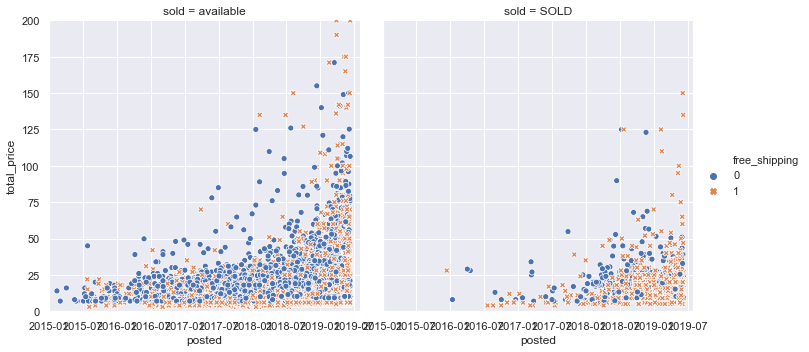

In [64]:
#Total price against date color coded by sold or for sale
%matplotlib inline
import seaborn as sns
book_plot = sns.relplot(x="posted", y="total_price", col="sold", hue = "free_shipping", style="free_shipping", data=books)
book_plot.set(xlim=(datetime.date(2015, 1, 1), datetime.date(2019, 8, 1)), ylim=(0,200))
book_plot


In [76]:
prop = 989/(21142+989)
print("The proportion of items that sell from total listings:", str(prop), "\nAbout 4.5%")

The proportion of items that sell from total listings: 0.044688446071121955 
About 4.5%


There seem to be a higher proporiton of free shipping purchases to non free shipping purchases in the sold graph!

In [ ]:
#Number of times a seller appears binned histogram

In [ ]:
#Number of times a seller appears and proportion of sold/for sale success

In [ ]:
#Sold to unsold and total prices

In [ ]:
#Sold to unsold and shipping